# Analysis of aggregated ETD data

In this notebook we load tables from our aggregated data folder. 
The analysis in this notebook builds on the previous two steps:
- Mapping raw data to mapped data
- Imputing, resampling and aggregating data

First we need to configure our ETD packages.

## Configuration

In [1]:
import etdmap
import etdtransform
import etdanalyze

# Set the standard etdmap options
etdmap.options.mapped_folder_path = "../../demodata/mapped_analyze" # change to path to folder where you would like to store mapped data
etdmap.options.bsv_metadata_file = "../../demodata/bsv_metadata_after_mapping.xlsx" # change to path to the Excel file with the data processor metadata (BSV is the data processor in this case)
etdmap.options.aggregate_folder_path = "../../demodata/aggregate"

etdtransform.options.mapped_folder_path = "../../demodata/mapped_analyze" # change to path to folder where you would like to store mapped data
etdtransform.options.aggregate_folder_path = "../../demodata/aggregate"

etdtransform.options.weather_data_folder_path = "../../demodata/weather_data/yearly"
etdtransform.options.weather_stations_summary_file = "../../demodata/weather_data/SummaryPerYear.xlsx"

## Load data

To start we load all the Ibis tables that hold the data. These are organized such that we can choose to pull out the data resampled in different intervals, e.g. 5 minutes vs. 24 hours.

We will retain one project for this example.

In [2]:
import ibis
from ibis import _
import ibis.selectors as s

household_tables = etdtransform.load_data.get_household_tables()

# get 5 minute data for households
household_table_5min = household_tables['5min']

project = 1

# select a single project for analysis
household_table_5min = household_table_5min.filter(_.ProjectIdBSV == project)


In [3]:
household_table_5min.head().to_pandas()

,ReadingDate,ProjectIdBSV,HuisIdBSV,ElektriciteitNetgebruikHoogDiff,ElektriciteitNetgebruikLaagDiff,ElektriciteitTerugleveringHoogDiff,ElektriciteitTerugleveringLaagDiff,ElektriciteitsgebruikWTWDiff,ElektriciteitsgebruikWarmtepompDiff,ElektriciteitsgebruikBoosterDiff,...,date_column,datetime_column,year,week_of_year,day_of_week,TemperatuurISOWk,GevoelstemperatuurISOWk,days_in_week,Koudste2ISOWkTemperatuur,Koudste2ISOWkGevoelstemperatuur
0,2019-01-01 00:05:00,1,1,0.0,0.000,0.0,0.0,0.00,0.00,0.0,...,2019-01-01,2019-01-01 01:00:00,2019,1,1,5.83125,1.242552,8,False,False
1,2019-01-01 00:10:00,1,1,0.0,0.135,0.0,0.0,0.00,0.05,0.0,...,2019-01-01,2019-01-01 01:00:00,2019,1,1,5.83125,1.242552,8,False,False
2,2019-01-01 00:15:00,1,1,0.0,0.116,0.0,0.0,0.00,0.01,0.0,...,2019-01-01,2019-01-01 01:00:00,2019,1,1,5.83125,1.242552,8,False,False
3,2019-01-01 00:20:00,1,1,0.0,0.106,0.0,0.0,0.00,0.01,0.0,...,2019-01-01,2019-01-01 01:00:00,2019,1,1,5.83125,1.242552,8,False,False
4,2019-01-01 00:25:00,1,1,0.0,0.106,0.0,0.0,0.01,0.01,0.0,...,2019-01-01,2019-01-01 01:00:00,2019,1,1,5.83125,1.242552,8,False,False


## Set variables of interest and normalize by surface area

In order to make our comparison like for like, we normalize the variables by the household surface area and set it to 100 meters squared.

In [4]:
# Choose variables of interest for our analysis
vars = [
    "Zelfgebruik",
    "ZonopwekBruto",
    "ElektriciteitsgebruikTotaalBruto",
    "TerugleveringTotaalNetto"
]

household_table_5min = household_table_5min.select(
    ['ReadingDate', 'ProjectIdBSV', 'HuisIdBSV'] + 
    vars + 
    ['Oppervlakte', 'Warmtebehoefte']
)


# Divide by surface area to normalize the data to 100m2 and convert to KWh
hh_table_normalized = etdanalyze.analysis_helpers.normalize_100m2(
    hh_table=household_table_5min, 
    interval="5min",
    col_names = vars
)

project_normalized = hh_table_normalized.group_by("ReadingDate", "ProjectIdBSV").aggregate([
    hh_table_normalized.ZelfgebruikPer100M2KW.mean().name("ZelfgebruikPer100M2KWH"),
    hh_table_normalized.ZonopwekBrutoPer100M2KW.mean().name("ZonopwekBrutoPer100M2KWH"),
    hh_table_normalized.ElektriciteitsgebruikTotaalBrutoPer100M2KW.mean().name("ElektriciteitsgebruikTotaalBrutoPer100M2KWH"),
    hh_table_normalized.TerugleveringTotaalNettoPer100M2KW.mean().name("TerugleveringTotaalNettoPer100M2KWH")
])



In [5]:
print(project_normalized.schema())

ibis.Schema {
  ReadingDate                                  timestamp(9)
  ProjectIdBSV                                 int64
  ZelfgebruikPer100M2KWH                       float64
  ZonopwekBrutoPer100M2KWH                     float64
  ElektriciteitsgebruikTotaalBrutoPer100M2KWH  float64
  TerugleveringTotaalNettoPer100M2KWH          float64
}


In [6]:
project_normalized.head().to_pandas()

,ReadingDate,ProjectIdBSV,ZelfgebruikPer100M2KWH,ZonopwekBrutoPer100M2KWH,ElektriciteitsgebruikTotaalBrutoPer100M2KWH,TerugleveringTotaalNettoPer100M2KWH
0,2019-10-11 07:30:00,1,0.002132,0.002132,0.543175,0.000000
1,2019-10-11 07:50:00,1,0.067145,0.067145,0.525649,0.000000
2,2019-10-11 08:30:00,1,0.144552,0.160935,0.461456,0.016383
3,2019-10-11 10:40:00,1,0.277472,0.593646,0.425542,0.316174
4,2019-10-11 11:40:00,1,0.341063,0.810002,0.491637,0.468939


## Produce a seasonal day profile

In [7]:


summer_table = project_normalized.filter(
    (_["ReadingDate"].month() == 6)
    | (_["ReadingDate"].month() == 7)
    | (_["ReadingDate"].month() == 8)
)

winter_table = project_normalized.filter(
    (_["ReadingDate"].month() == 12)
    | (_["ReadingDate"].month() == 1)
    | (_["ReadingDate"].month() == 2)
)


In [8]:
summer_table.head().to_pandas()

,ReadingDate,ProjectIdBSV,ZelfgebruikPer100M2KWH,ZonopwekBrutoPer100M2KWH,ElektriciteitsgebruikTotaalBrutoPer100M2KWH,TerugleveringTotaalNettoPer100M2KWH
0,2019-06-01 00:25:00,1,0.0,0.0,0.312193,0.0
1,2019-06-01 00:35:00,1,0.0,0.0,0.347553,0.0
2,2019-06-01 00:50:00,1,0.0,0.0,0.311570,0.0
3,2019-06-01 01:15:00,1,0.0,0.0,0.338389,0.0
4,2019-06-01 03:15:00,1,0.0,0.0,0.393386,0.0


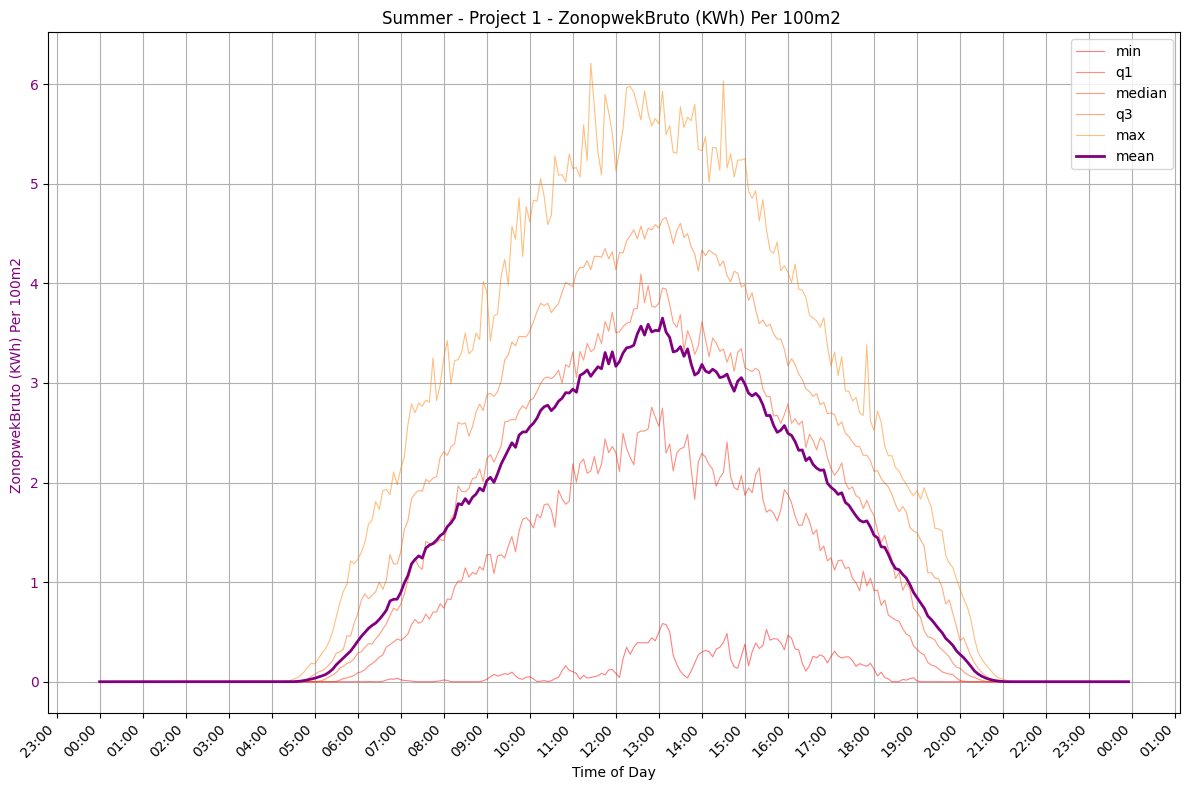

In [9]:
# plot_var = "ElektriciteitsgebruikTotaalBrutoPer100M2KW"
# plot_var_name = "Elektriciteitsgebruik Totaal Bruto"

plot_var = "ZonopwekBrutoPer100M2KWH"
plot_var_name = "ZonopwekBruto (KWh) Per 100m2 "


fig = etdanalyze.plot_functions.plot_daily_profile(
    df = summer_table.to_pandas(),
    title = f"Summer - Project {project} - {plot_var_name}",
    plot_var=plot_var,
    plot_var_name=plot_var_name
)

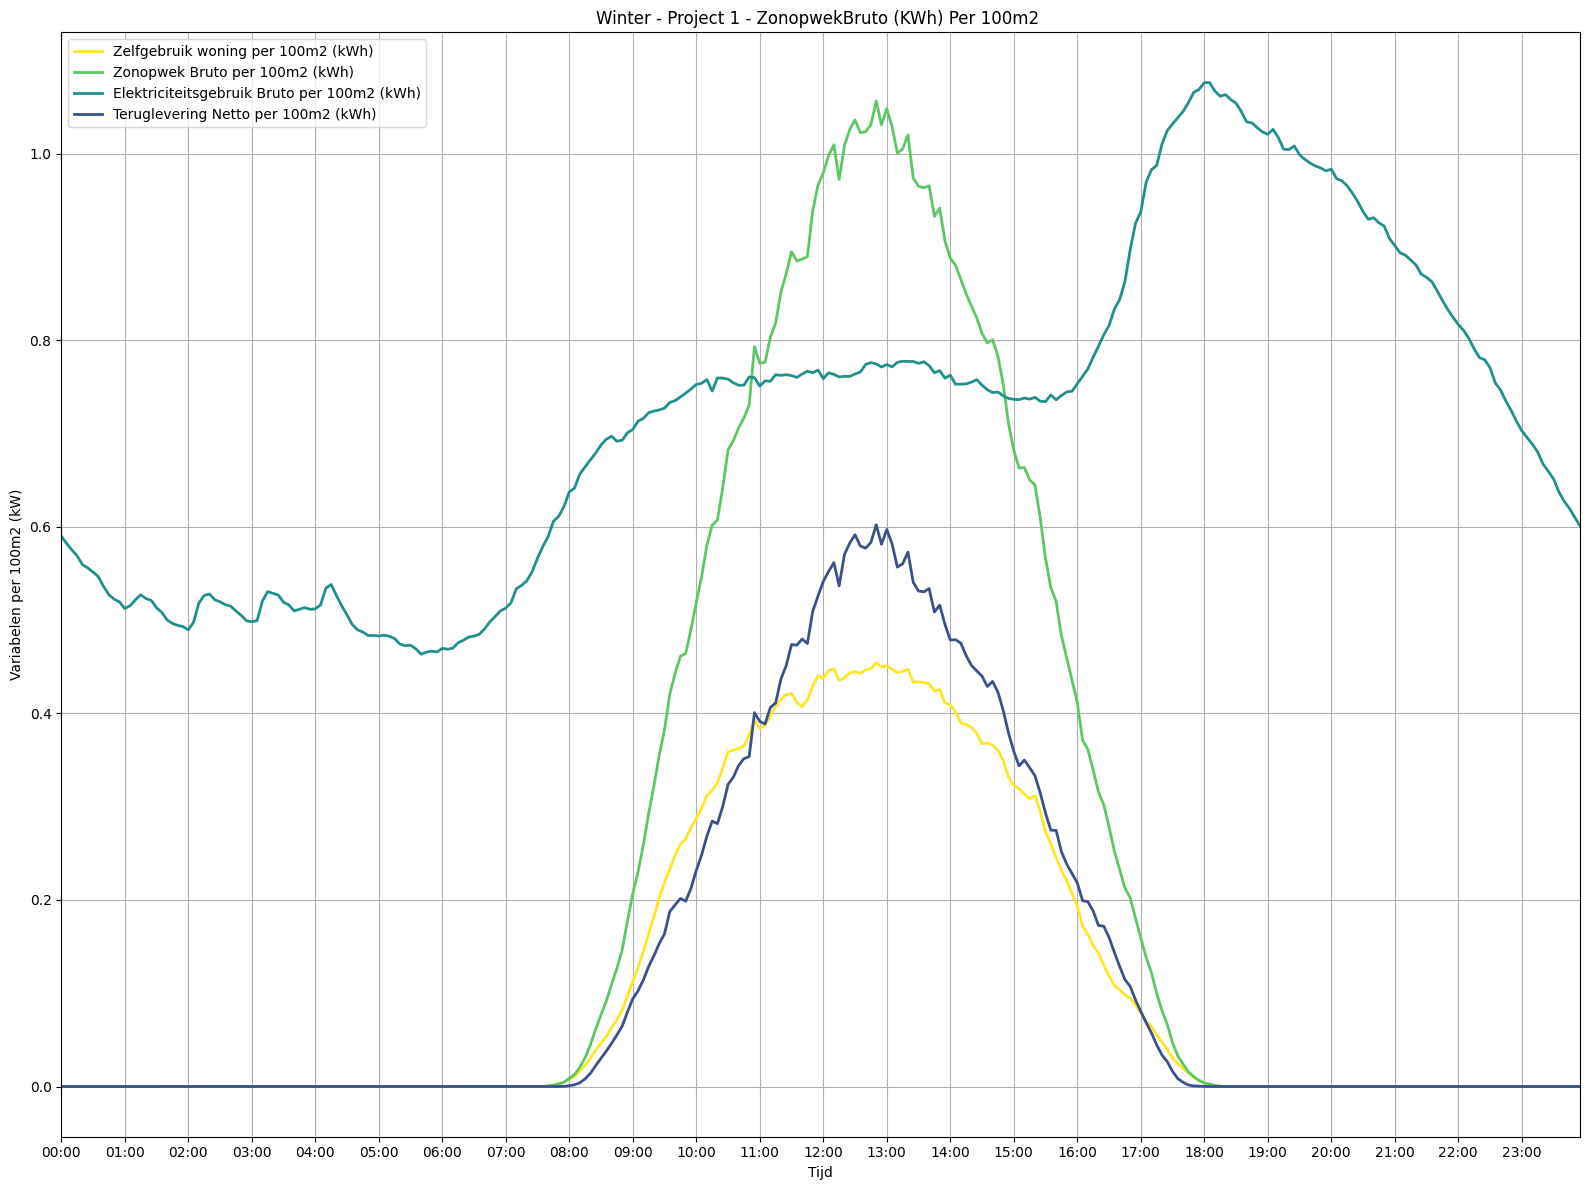

In [10]:
plot_vars = {
    "ZelfgebruikPer100M2KWH": "Zelfgebruik woning per 100m2 (kWh)",
    "ZonopwekBrutoPer100M2KWH": "Zonopwek Bruto per 100m2 (kWh)",
    "ElektriciteitsgebruikTotaalBrutoPer100M2KWH": "Elektriciteitsgebruik Bruto per 100m2 (kWh)",
    "TerugleveringTotaalNettoPer100M2KWH": "Teruglevering Netto per 100m2 (kWh)",
}

fig = etdanalyze.plot_functions.plot_daily_profile_mean_combined(
df = winter_table.to_pandas(),
title = f"Winter - Project {project} - {plot_var_name}",
plot_vars=plot_vars.keys(),
# plot_interval=plot_interval,
plot_var_names=plot_vars.values()
)

## Produce a load duration curve

In [11]:
# It is also possible to load project data directly
project_tables = etdtransform.load_data.get_project_tables()

In [12]:
project_5min_table = project_tables["5min"]
print(project_5min_table.schema())
print(project)

ibis.Schema {
  index                                      int64
  ReadingDate                                timestamp(9)
  ProjectIdBSV                               int64
  ElektriciteitNetgebruikHoogDiff            float64
  ElektriciteitNetgebruikLaagDiff            float64
  ElektriciteitTerugleveringHoogDiff         float64
  ElektriciteitTerugleveringLaagDiff         float64
  ElektriciteitsgebruikWTWDiff               float64
  ElektriciteitsgebruikWarmtepompDiff        float64
  ElektriciteitsgebruikBoosterDiff           float64
  ElektriciteitsgebruikBoilervatDiff         float64
  ElektriciteitsgebruikRadiatorDiff          float64
  ZonopwekBruto                              float64
  TerugleveringTotaalNetto                   float64
  ElektriciteitsgebruikTotaalNetto           float64
  Netuitwisseling                            float64
  ElektriciteitsgebruikTotaalWarmtepomp      float64
  ElektriciteitsgebruikTotaalGebouwgebonden  float64
  ElektriciteitsgebruikTotaalHu

In [13]:
plot_var = "ElektriciteitsgebruikTotaalNetto"

filtered_table = project_5min_table.filter(
    _.ProjectIdBSV == project
).select(["ReadingDate", "ProjectIdBSV"] + [plot_var])

ElektriciteitsgebruikTotaalNetto stats for 5min - Project None: 0.30% above 1.5 kW


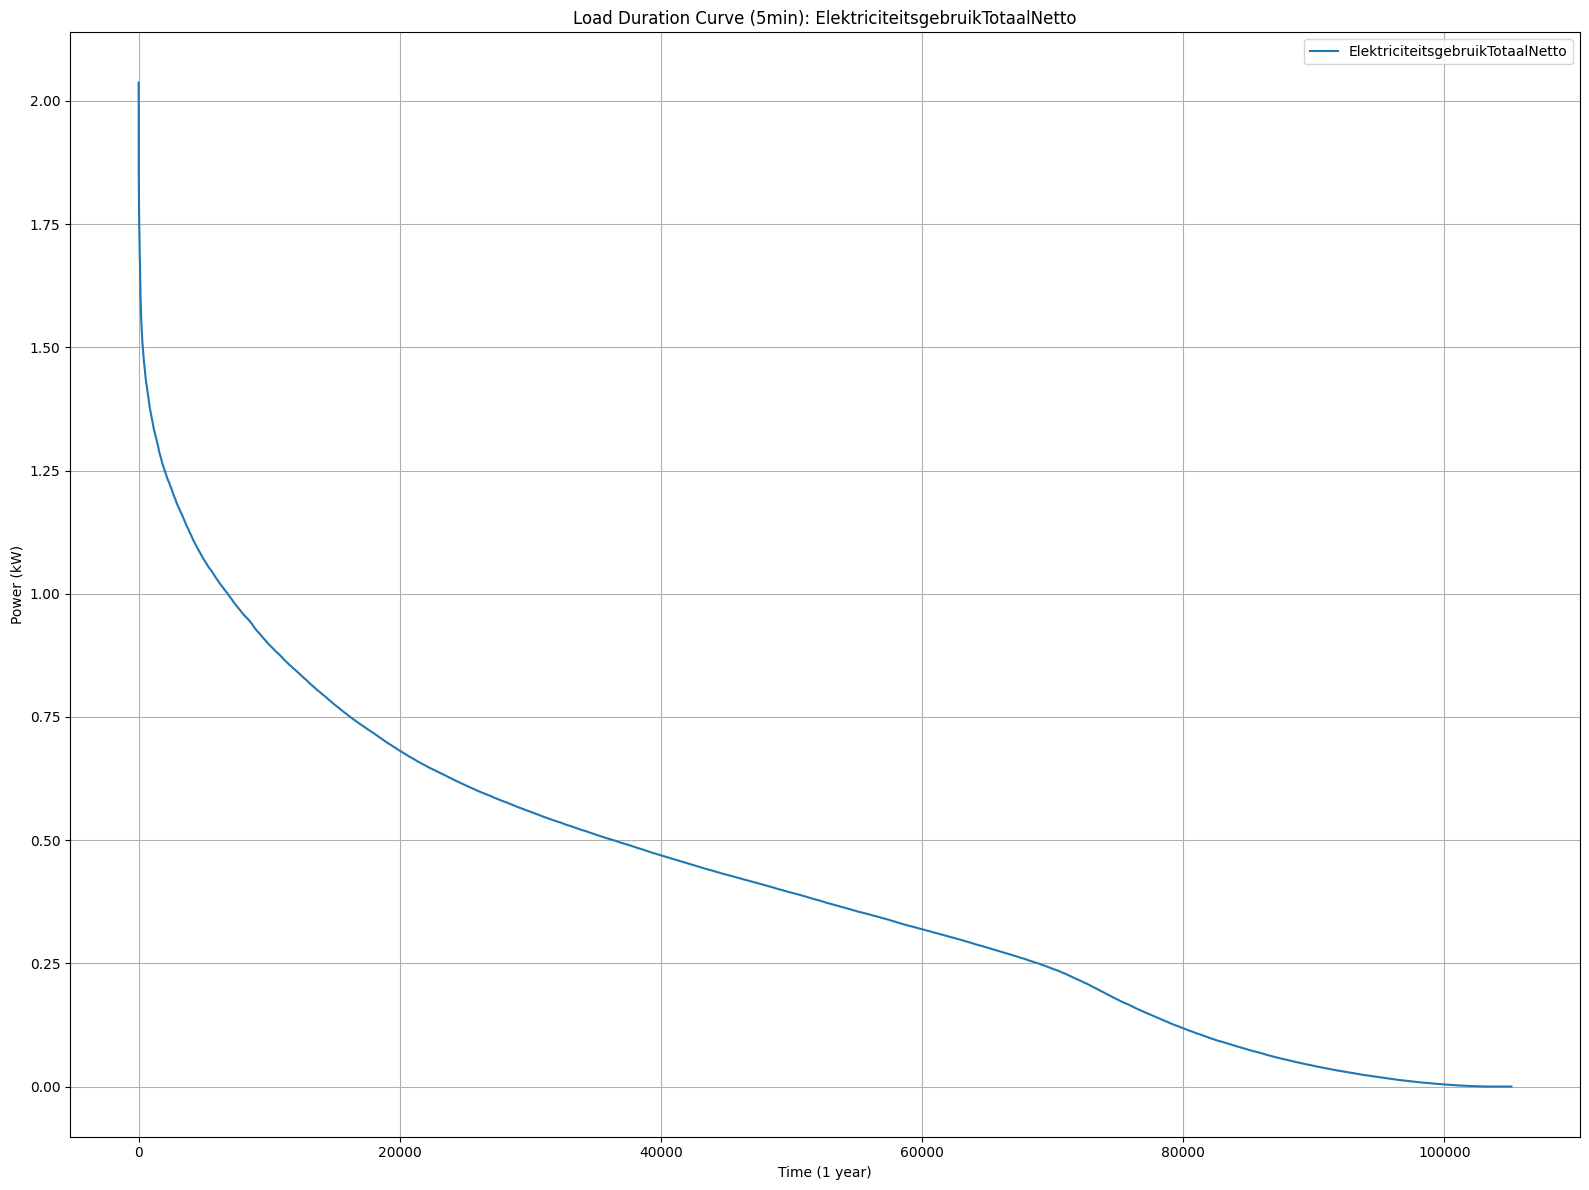

In [14]:
fig = etdanalyze.plot_functions.plot_load_duration_curve(
    df=filtered_table.to_pandas(),
    diff_column=plot_var,
    interval="5min"
)

## Produce a graph of the coldest week

In [17]:
coldest_table = project_5min_table.filter(
    _.ProjectIdBSV == project,
    _.Koudste2WkTemperatuur == True
).select(["ReadingDate", "ProjectIdBSV", "Temperatuur"] + [plot_var])


coldest_table.schema()

ibis.Schema {
  ReadingDate                       timestamp(9)
  ProjectIdBSV                      int64
  Temperatuur                       float64
  ElektriciteitsgebruikTotaalNetto  float64
}

In [ ]:
fig = etdanalyze.plot_functions.plot_var_vs_temp(
    coldest_table.to_pandas(),
    var = plot_var,
    title = "Coldest two weeks"
)